# Walmart Sales Analysis and Insights (M5 Dataset)
**Autor:** Miguel Ángel  
**Fecha:** Septiembre 2025  

Exploratory Data Analysis (EDA) of Walmart sales data (M5 dataset). The notebook covers data cleaning, SQL-based queries, and Python visualizations to uncover insights on sales performance across stores, categories, and time periods.

The analysis focuses on:
- Data modeling and preparation  
- SQL queries for key business insights  
- Python visualizations (pandas, matplotlib)  

## 1. Importing Libraries

In [1]:
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt

## 2. Data Integrity Analysis

The original sales_train_validation.csv file contains daily sales data for each product and store, where each day *(d_1 … d_1913)* is represented as a separate column. To facilitate analysis, the table was reshaped from a wide format to a long format using the melt function. In the transformed table *(sales_long)*, each row now represents a unique combination of product, store, and day (d), with the corresponding number of units sold. This structure makes it easier to perform aggregations, joins with the calendar and price tables, and time-series analysis.

In [ ]:
sales_original = pd.read_csv("sales_train_validation.csv")
id_columns = ["item_id", "dept_id", "cat_id", "store_id"]
value_columns = [c for c in sales_original.columns if c.startswith("d_")]

sales_formatted = sales_original.melt(
    id_vars = id_columns,
    value_vars = value_columns,
    var_name = "d",   
    value_name = "sales"
)

sales_formatted.to_csv("sales_formatted.csv", index=False)
## Execution time: 1m 27s

The calendar dataset includes two sets of event columns *(event_name_1, event_type_1 and event_name_2, event_type_2)* because a single day may have multiple events *(e.g., Super Bowl and Cinco de Mayo on the same day)*.
In this analysis, I kept the dataset in its original form for simplicity and because it does not affect data integrity. However, as a potential improvement, these event columns could be normalized into a separate table with one event per row, making the analysis of multiple events on the same day easier and more scalable.

### Importing CSV Files

In [ ]:
calendar = pd.read_csv("calendar.csv")
sales_formatted = pd.read_csv("sales_formatted.csv")
sell_prices = pd.read_csv("sell_prices.csv")

In [ ]:
# Analyze general structure
calendar.info()
sales_formatted.info()
sell_prices.info()

In [ ]:
# Reviewing null data
calendar.isnull().sum() # -> Only nulls in events
sales_formatted.isnull().sum() # -> Not nulls
sell_prices.isnull().sum() # -> Not nulls

In [ ]:
# Reviewing duplicated data
calendar.duplicated().sum() # -> There's no duplicated data
sales_formatted.duplicated().sum() # -> There's no duplicated data
sell_prices.duplicated().sum() # -> There's no duplicated data

In [ ]:
# Validating keys and relationships
sales_formatted.set_index(["store_id", "item_id", "d"]).index.is_unique # -> There's no duplicated data that violate ingregity
sell_prices.set_index(["store_id", "item_id", "wm_yr_wk"]).index.is_unique # -> There's no duplicated data that violate ingregity

In [ ]:
# Reviewing range and logic values
(sales_formatted["sales"] < 0).sum() # -> No negative sales
(sell_prices["sell_price"] < 0).sum() # -> No negative prices

In [ ]:
# Reviewing date types
calendar["date"].min(), calendar["date"].max() # ('2011-01-29', '2016-06-19')
len(calendar) # -> 1969 days in the record
calendar.groupby("wm_yr_wk")["d"].count().value_counts().head()
# 281 commercial weeks of 7 days and 1 week of just two days (the first week of the record)7
# California (4), Texas (3), and Wisconsin (3)
# 3049 number of products
# 58,327,370 sale transactions

## 3. Database connection

In [2]:
connection = db.connect("DRIVER={ODBC Driver 17 for SQL Server};SERVER=MIGUESGO;DATABASE=M5_Forcasting;Trusted_Connection=yes;")

## 4. Analytics

In [3]:
# Number of pruducts sold in all the period
query = """
    SELECT SUM(sales) AS unidades_vendidas
    FROM dbo.sales_formatted;
"""

unidades_vendidas = pd.read_sql(query, connection)
unidades_vendidas # 65,695,409 units

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\746589058.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  unidades_vendidas = pd.read_sql(query, connection)


,unidades_vendidas
0,65695409


In [4]:
# Total sales in all the period
query = """
    SELECT SUM(S.sales * SP.sell_price) AS total_revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON S.d = C.d
    JOIN dbo.sell_prices AS SP
        ON SP.item_id = S.item_id
        AND SP.store_id = S.store_id
        AND SP.wm_yr_wk = C.wm_yr_wk;
"""

total_revenue = pd.read_sql(query, connection)
float(total_revenue["total_revenue"]) # -> $ 187,676,570.01990828

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\3673675829.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_revenue = pd.read_sql(query, connection)
C:\Users\migue\AppData\Local\Temp\ipykernel_18736\3673675829.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(total_revenue["total_revenue"]) # -> $ 187,676,570.01990828


187676570.01991022

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2561718855.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_year = pd.read_sql(query, connection)


   year  total_sales_by_year
0  2011                 8.86
1  2012                12.06
2  2013                13.14
3  2014                13.09
4  2015                13.80
5  2016                 4.75


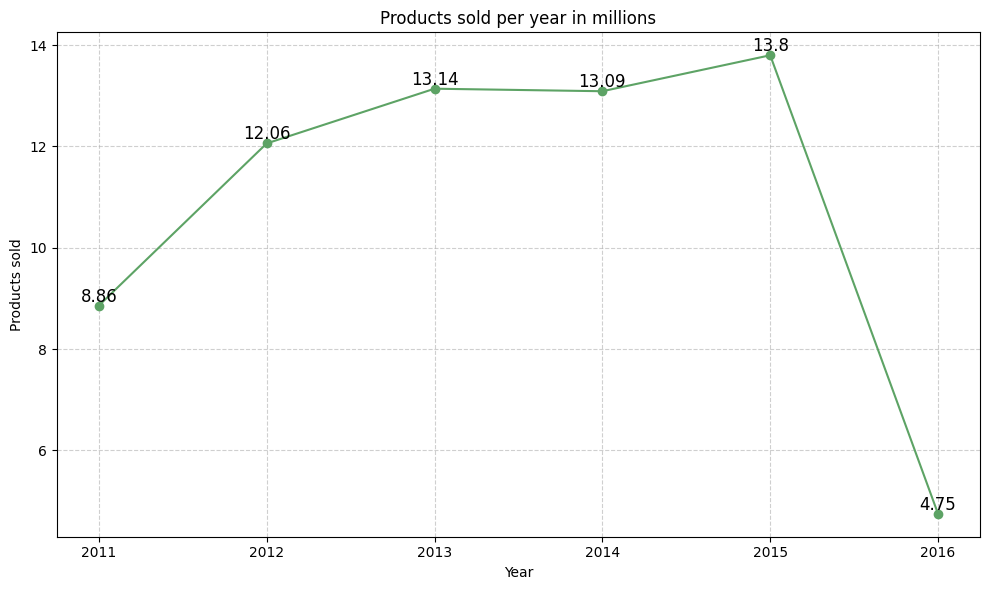

In [5]:
# Products sold per year in millions
query = """
    SELECT C.year,
	   SUM(S.sales) AS total_sales_by_year
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    GROUP BY C.year
    ORDER BY C.year
"""
total_sales_by_year = pd.read_sql(query, connection)
total_sales_by_year["total_sales_by_year"] = (
    round(total_sales_by_year["total_sales_by_year"] / 1000000, 2)
)
print(total_sales_by_year)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(total_sales_by_year["year"],
        total_sales_by_year["total_sales_by_year"],
        marker="o",
        linestyle="-",
        color="#5DA365")
for x, y in zip(total_sales_by_year["year"], total_sales_by_year["total_sales_by_year"]):
    ax.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=12)
ax.set_title("Products sold per year in millions")
ax.set_xlabel("Year")
ax.set_ylabel("Products sold")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2519992045.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_revenue = pd.read_sql(query, connection)


   year  total_revenue
0  2011          23.89
1  2012          32.65
2  2013          35.92
3  2014          37.86
4  2015          42.42
5  2016          14.93


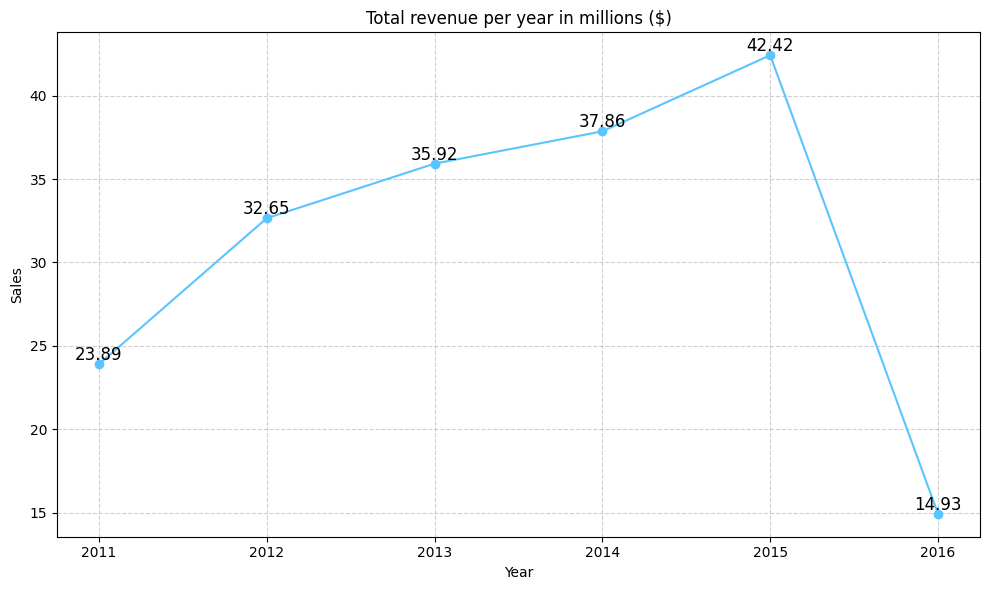

In [6]:
# Total revenue per year in millions
query = """
    SELECT C.year,
        SUM(S.sales * SP.sell_price) AS total_revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    JOIN dbo.sell_prices AS SP
        ON SP.store_id = S.store_id
        AND SP.item_id = S.item_id
        AND SP.wm_yr_wk = C.wm_yr_wk
    GROUP BY C.year;
"""
total_revenue = pd.read_sql(query, connection)
total_revenue["total_revenue"] = (
    round(total_revenue["total_revenue"] / 1000000, 2)
)
print(total_revenue)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(total_revenue["year"],
        total_revenue["total_revenue"],
        marker="o",
        linestyle="-",
        color="#59C5FF")
for x, y in zip(total_revenue["year"], total_revenue["total_revenue"]):
    ax.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=12)
ax.set_title("Total revenue per year in millions ($)")
ax.set_xlabel("Year")
ax.set_ylabel("Sales")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2731777502.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_from_item = pd.read_sql(query, connection)


           store_item  max_sales
0  CA_1 - FOODS_3_090     127203
1  CA_2 - FOODS_3_586      63416
2  CA_3 - FOODS_3_090     250502
3  CA_4 - FOODS_3_090      52264
4  TX_1 - FOODS_3_586     112454
5  TX_2 - FOODS_3_586     192835
6  TX_3 - FOODS_3_586     150122
7  WI_1 - FOODS_3_226      78993
8  WI_2 - FOODS_3_226      69966
9  WI_3 - FOODS_3_090     121434


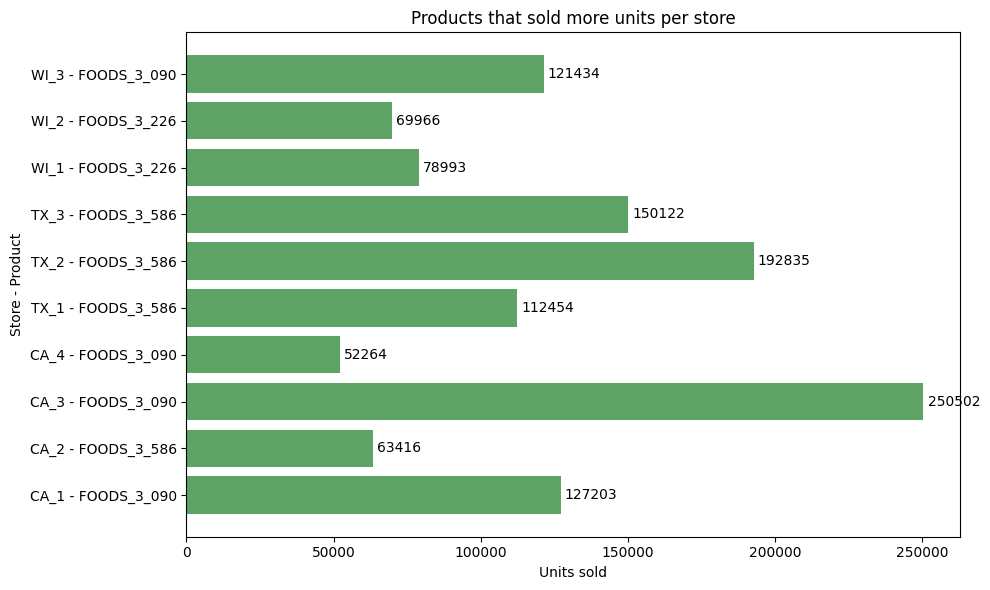

In [7]:
# -- Product that sold more units per store
query = """
    WITH total_sales_from_item AS (
        -- Total sales from every item in all stores
        SELECT store_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY store_id, item_id
    ), max_sales_from_store AS (
        -- Max sales from every store
        SELECT store_id,
        MAX(total_sales) as max_sales
        FROM total_sales_from_item
        GROUP BY store_id
    )
    SELECT TS.store_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_from_item AS TS
    JOIN max_sales_from_store AS MS
        ON TS.store_id = MS.store_id
        AND TS.total_sales = MS.max_sales
    ORDER BY store_id;
"""
total_sales_from_item = pd.read_sql(query, connection)
total_sales_from_item["store_item"] = (
    total_sales_from_item["store_id"] + " - " + total_sales_from_item["item_id"] 
)
print(total_sales_from_item[["store_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(total_sales_from_item["store_item"],
               total_sales_from_item["max_sales"],
               color="#5DA365")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Products that sold more units per store")
ax.set_xlabel("Units sold")
ax.set_ylabel("Store - Product")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2304546240.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_product = pd.read_sql(query, connection)


                       dept_item  max_sales
0          FOODS_1 - FOODS_1_218     234594
1          FOODS_2 - FOODS_2_360     257119
2          FOODS_3 - FOODS_3_090    1002529
3      HOBBIES_1 - HOBBIES_1_371     122565
4      HOBBIES_2 - HOBBIES_2_142      24611
5  HOUSEHOLD_1 - HOUSEHOLD_1_334     171275
6  HOUSEHOLD_2 - HOUSEHOLD_2_176      36283


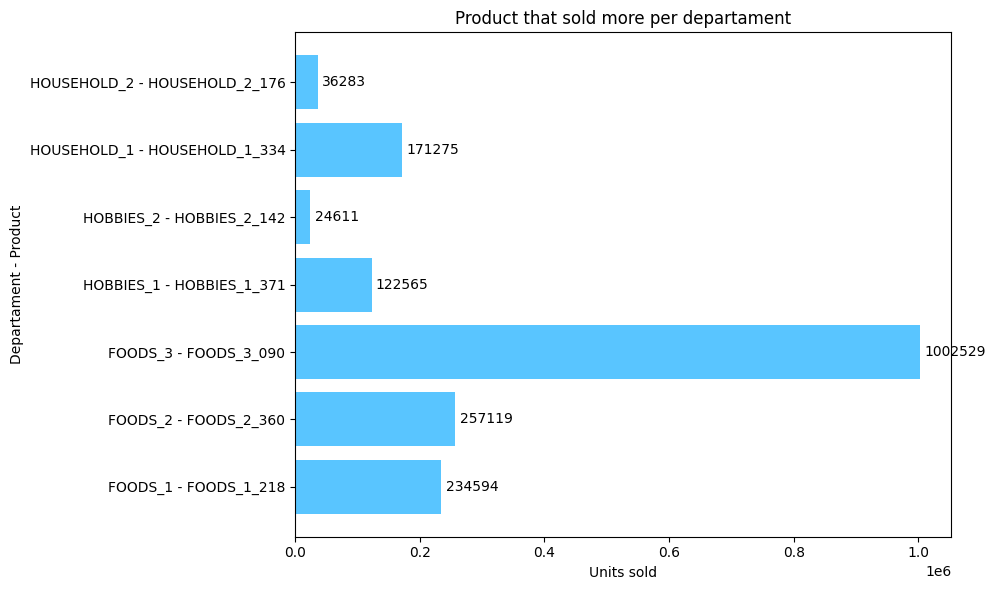

In [8]:
# -- Product that sold more items per department
query = """
    WITH total_sales_by_product AS (
        -- total sales by product overall
        SELECT dept_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY dept_id, item_id
    ), max_sales AS (
        SELECT dept_id,
            MAX(total_sales) AS max_sales
        FROM total_sales_by_product
        GROUP BY dept_id
    )
    SELECT TS.dept_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_by_product AS TS
    JOIN max_sales AS MS
        ON TS.dept_id = MS.dept_id
        AND TS.total_sales = MS.max_sales
    ORDER BY dept_id;
"""

total_sales_by_product = pd.read_sql(query, connection)
total_sales_by_product["dept_item"] = (
    total_sales_by_product["dept_id"] + " - " + total_sales_by_product["item_id"]
)
print(total_sales_by_product[["dept_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(total_sales_by_product["dept_item"],
               total_sales_by_product["max_sales"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Product that sold more per departament")
ax.set_xlabel("Units sold")
ax.set_ylabel("Departament - Product")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2769238699.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_product = pd.read_sql(query, connection)


                      cat_item  max_sales
0          FOODS - FOODS_3_090    1002529
1      HOBBIES - HOBBIES_1_371     122565
2  HOUSEHOLD - HOUSEHOLD_1_334     171275


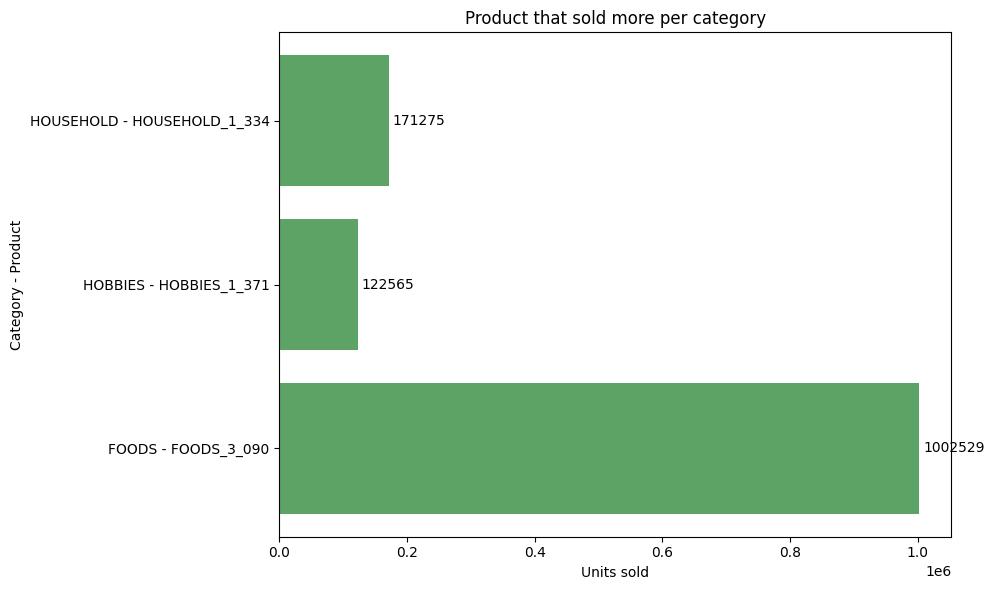

In [9]:
# -- Product that sold more units per category
query = """
    WITH total_sales_by_product AS (
        -- total sales by product overall
        SELECT cat_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY cat_id, item_id
    ), max_sales AS (
        SELECT cat_id,
            MAX(total_sales) AS max_sales
        FROM total_sales_by_product
        GROUP BY cat_id
    )
    SELECT TS.cat_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_by_product AS TS
    JOIN max_sales AS MS
        ON TS.cat_id = MS.cat_id
        AND TS.total_sales = MS.max_sales
    ORDER BY cat_id;
"""

total_sales_by_product = pd.read_sql(query, connection)
total_sales_by_product["cat_item"] = (
    total_sales_by_product["cat_id"] + " - " + total_sales_by_product["item_id"]
)
print(total_sales_by_product[["cat_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(total_sales_by_product["cat_item"],
               total_sales_by_product["max_sales"],
               color="#5DA365")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Product that sold more per category")
ax.set_xlabel("Units sold")
ax.set_ylabel("Category - Product")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\3541771149.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_three_products = pd.read_sql(query, connection)


  store_id      item_id  total_sales
0     CA_1  FOODS_3_090       127203
1     CA_1  FOODS_3_586        87691
2     CA_1  FOODS_3_252        74971
3     CA_2  FOODS_3_586        63416
4     CA_2  FOODS_3_252        57328


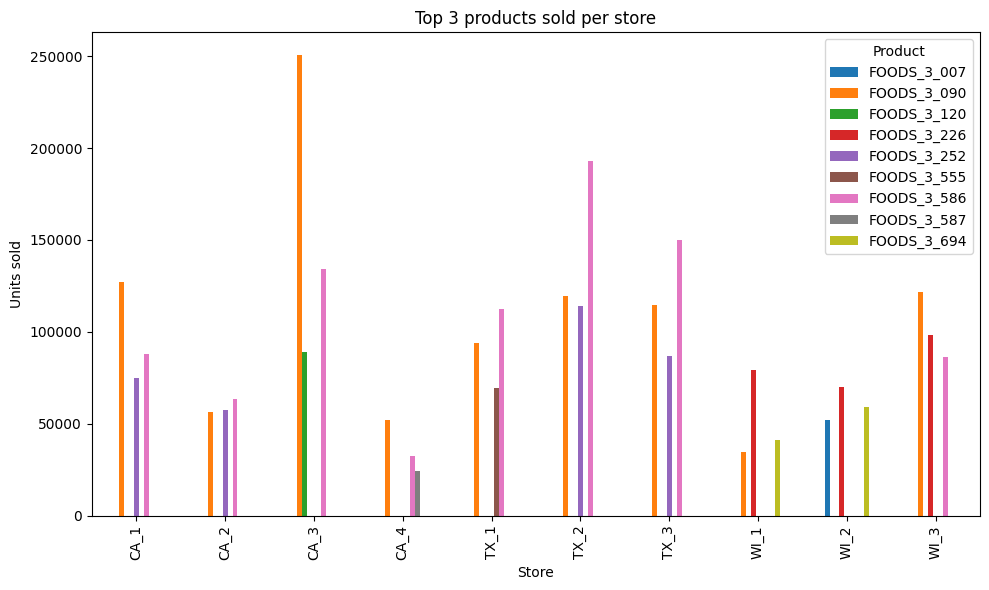

In [10]:
# Top thre products per store
query = """
    -- TOP 3 products that sold more units by store
    WITH top_three_products AS (
        SELECT store_id,
            item_id,
            SUM(sales) AS total_sales,
            ROW_NUMBER() OVER (
                    PARTITION BY store_id
                    ORDER BY SUM(sales) DESC
            ) AS rn
        FROM dbo.sales_formatted
        GROUP BY store_id, item_id
    )
    SELECT store_id,
        item_id,
        total_sales
    FROM top_three_products
    WHERE rn <= 3
    ORDER BY store_id, rn
"""

top_three_products = pd.read_sql(query, connection)
print(top_three_products.head())

fig, ax = plt.subplots(figsize=(10, 6))
pivot = top_three_products.pivot(index="store_id",
                                 columns="item_id",
                                 values="total_sales")
pivot.plot(kind="bar", ax=ax)

ax.set_title("Top 3 products sold per store")
ax.set_xlabel("Store")
ax.set_ylabel("Units sold")
ax.legend(title="Product")
plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\4002977207.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  revenue = pd.read_sql(query, connection)


  store_id     cat_id      revenue
0     CA_1      FOODS  13380549.24
1     CA_1    HOBBIES   3158380.74
2     CA_1  HOUSEHOLD   5981322.40
3     CA_2      FOODS   8552002.10
4     CA_2    HOBBIES   2162823.27


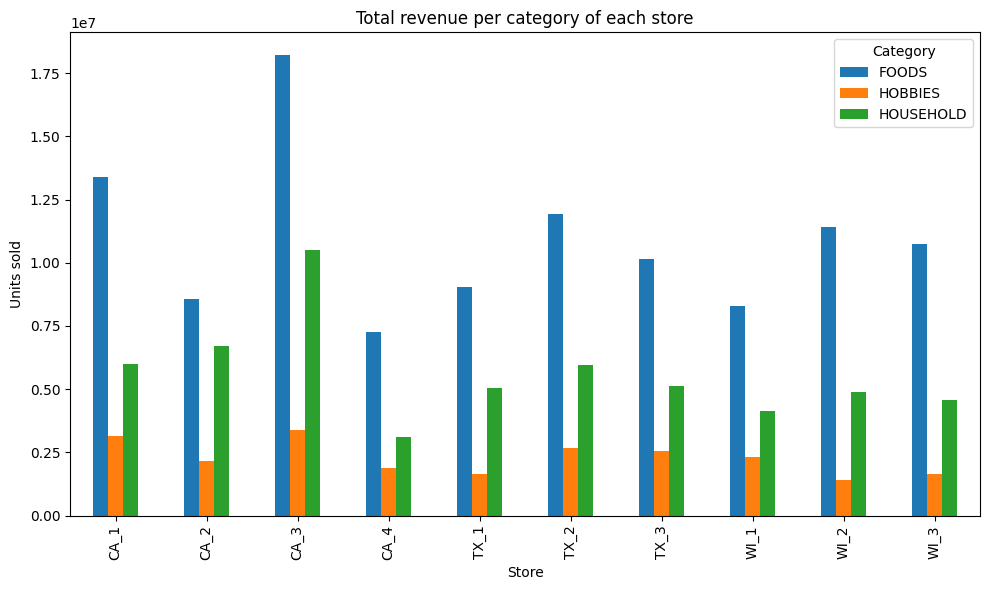

In [11]:
# Top three products per category
query = """
    -- Total revenue by store and category
    SELECT S.store_id,
        S.cat_id,
        SUM(S.sales * SP.sell_price) AS revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    JOIN dbo.sell_prices AS SP
        ON SP.item_id = S.item_id
        AND SP.store_id = S.store_id
        AND SP.wm_yr_wk = C.wm_yr_wk
    GROUP BY S.store_id, S.cat_id
    ORDER BY S.store_id, cat_id, revenue
"""
revenue = pd.read_sql(query, connection)
print(revenue.head())

fig, ax = plt.subplots(figsize=(10, 6))
pivot = revenue.pivot(index="store_id",
                      columns="cat_id",
                      values="revenue")
pivot.plot(kind="bar", ax=ax)

ax.set_title("Total revenue per category of each store")
ax.set_xlabel("Store")
ax.set_ylabel("Units sold")
ax.legend(title="Category")
plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\945776101.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weekday = pd.read_sql(query, connection)


     weekday  sum_units
0  Wednesday       8.19
1   Thursday       8.25
2    Tuesday       8.29
3     Monday       8.97
4     Friday       9.34
5     Sunday      11.27
6   Saturday      11.38


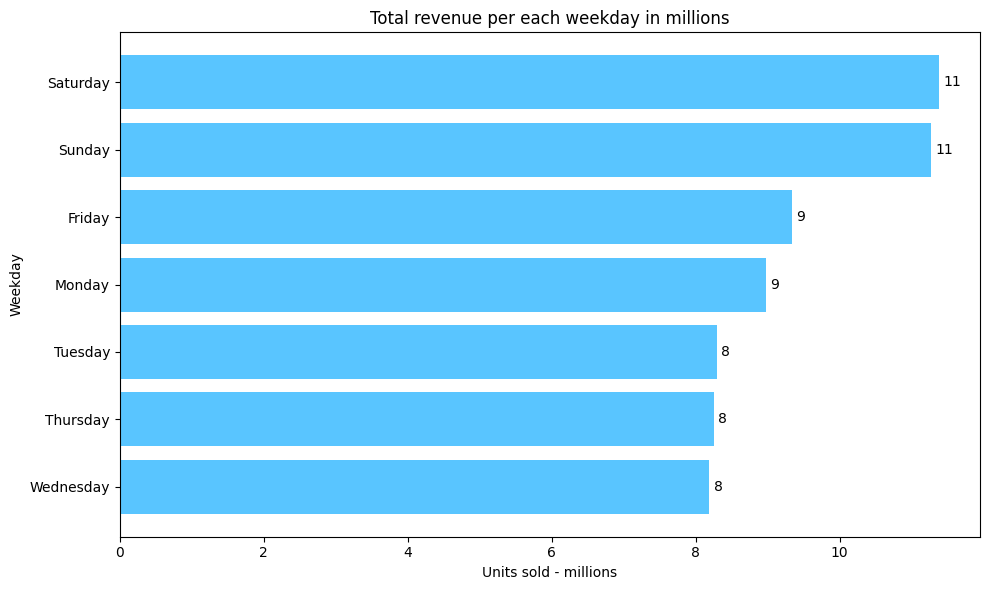

In [12]:
# Total sales per weekday
query = """
    SELECT C.weekday,
	   SUM(S.sales) AS sum_units
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    GROUP BY C.weekday
    ORDER BY sum_units
"""

weekday = pd.read_sql(query, connection)
weekday["sum_units"] = (
    round(weekday["sum_units"] / 1000000, 2)
)
print(weekday)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(weekday["weekday"],
               weekday["sum_units"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Total revenue per each weekday in millions")
ax.set_xlabel("Units sold - millions")
ax.set_ylabel("Weekday")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\2701583792.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_sales = pd.read_sql(query, connection)


      event_name  total_units
1      SuperBowl       245544
2      Purim End       215742
3       LaborDay       210773
4  PresidentsDay       206678
5  ValentinesDay       200974


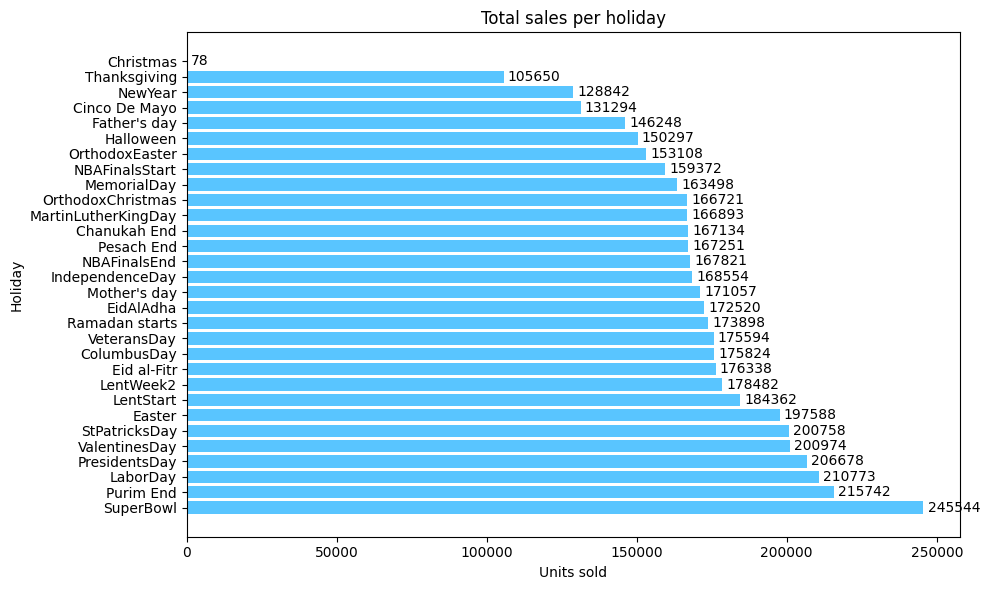

In [13]:
# -- Total sales per holiday
query = """
    SELECT 
        COALESCE(C.event_name_1, C.event_name_2) AS event_name,
        SUM(S.sales) AS total_units
    FROM dbo.sales_formatted S
    JOIN dbo.calendar C ON C.d = S.d
    WHERE C.event_name_1 IS NOT NULL OR C.event_name_2 IS NOT NULL
    GROUP BY COALESCE(C.event_name_1, C.event_name_2)
    ORDER BY total_units DESC;
"""

event_sales = pd.read_sql(query, connection)
event_sales = event_sales[1:]
print(event_sales.head())

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(event_sales["event_name"],
               event_sales["total_units"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Total sales per holiday")
ax.set_xlabel("Units sold")
ax.set_ylabel("Holiday")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18736\3728021983.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_percentages = pd.read_sql(query, connection)


  store_id  total_sales_per_store  total_profit_per_store  \
0     CA_4                4103676            1.220715e+07   
1     WI_1                5149062            1.476924e+07   
2     TX_1                5595292            1.572916e+07   
3     CA_2                5685475            1.740944e+07   
4     TX_3                6089330            1.779673e+07   
5     WI_3                6427782            1.692691e+07   
6     WI_2                6544012            1.769074e+07   
7     TX_2                7214384            2.051824e+07   
8     CA_1                7698216            2.252025e+07   
9     CA_3               11188180            3.210872e+07   

   total_sales_percentage  total_profit_percentage  
0                    6.25                     6.50  
1                    7.84                     7.87  
2                    8.52                     8.38  
3                    8.65                     9.28  
4                    9.27                     9.48  
5         

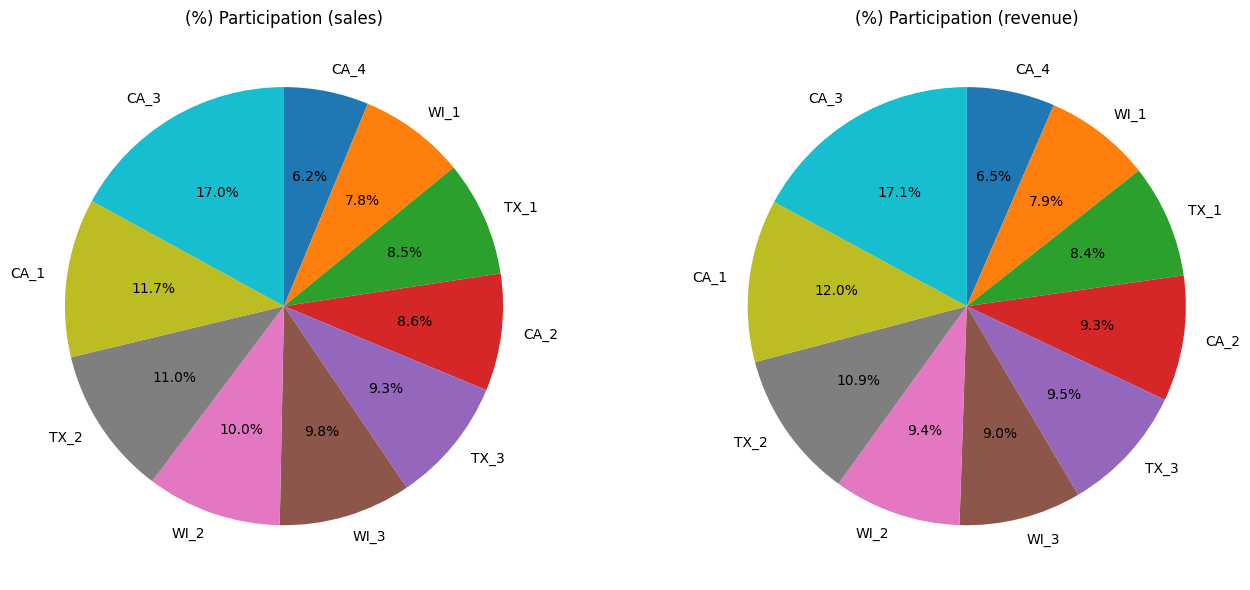

In [15]:
# -- Percentage of revenue and sales from every store
query = """
    WITH quantity_sales_per_store AS (
        SELECT S.store_id,
            SUM(S.sales) AS total_sales_per_store,
            SUM(S.sales * SP.sell_price) AS total_profit_per_store
        FROM dbo.sales_formatted AS S
        JOIN dbo.calendar AS C ON C.d = S.d
        JOIN dbo.sell_prices AS SP
            ON SP.item_id = S.item_id
            AND SP.store_id = S.store_id
            AND SP.wm_yr_wk = C.wm_yr_wk
        GROUP BY S.store_id
    ), quantity_sales_overall AS (
        SELECT SUM(S.sales) AS total_sales_overall,
            SUM(S.sales * SP.sell_price) AS total_profit_overall
        FROM dbo.sales_formatted AS S
        JOIN dbo.calendar AS C ON C.d = S.d
        JOIN dbo.sell_prices AS SP
            ON SP.item_id = S.item_id
            AND SP.store_id = S.store_id
            AND SP.wm_yr_wk = C.wm_yr_wk
    )
    SELECT QSS.store_id,
        QSS.total_sales_per_store,
        QSS.total_profit_per_store,
        ROUND(100.0 * QSS.total_sales_per_store / QSO.total_sales_overall, 2) AS total_sales_percentage,
        ROUND(100.0 * QSS.total_profit_per_store / QSO.total_profit_overall, 2) AS total_profit_percentage
    FROM quantity_sales_per_store AS QSS
    CROSS JOIN quantity_sales_overall AS QSO
    ORDER BY total_sales_percentage, total_profit_percentage;
"""

total_percentages = pd.read_sql(query, connection)
print(total_percentages)

# Crear dos gráficos de pastel lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Primer pastel: porcentaje de ventas en unidades
axes[0].pie(total_percentages["total_sales_percentage"],
            labels=total_percentages["store_id"],
            autopct="%.1f%%",
            startangle=90,
            counterclock=False)
axes[0].set_title("(%) Participation (sales)")

# Segundo pastel: porcentaje de ventas en dinero (profit)
axes[1].pie(total_percentages["total_profit_percentage"],
            labels=total_percentages["store_id"],
            autopct="%.1f%%",
            startangle=90,
            counterclock=False)
axes[1].set_title("(%) Participation (revenue)")

plt.tight_layout()
plt.show()